# <B> Chatbot with Profile Schema

In [2]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

### Defining a user profile schema

In [1]:
from typing import TypedDict , List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str # The user's prefered name
    interests: List[str] # A list of the user's interests

### Saving a schema to the store

In [2]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Pandhari" , 
    "interests": ["biking" , "technology" , "coffee"]
}
user_profile

{'user_name': 'Pandhari', 'interests': ['biking', 'technology', 'coffee']}

In [3]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id , "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory , key , value)

In [4]:
# Search
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Pandhari', 'interests': ['biking', 'technology', 'coffee']}, 'created_at': '2025-05-21T04:10:47.836536+00:00', 'updated_at': '2025-05-21T04:10:47.836538+00:00', 'score': None}


In [5]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory , "user_profile")
profile.value

{'user_name': 'Pandhari', 'interests': ['biking', 'technology', 'coffee']}

### Chatbot with profile schema

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
from pydantic import BaseModel , Field

from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq

# Initialize the model
model = ChatGroq(model=os.getenv("GROQ_MODEL_NAME") , temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Pandhari, I like to bike")])
structured_output

{'user_name': 'Pandhari', 'interests': ['biking']}

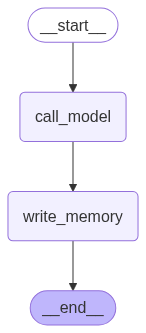

In [8]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [12]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Pandhari and I like to bike around Pune and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Pandhari and I like to bike around Pune and eat at bakeries.
================================== Ai Message ==================================

Welcome back, Pandhari. I remember we spoke earlier about your interests in biking around Pune and trying out bakeries. How's your biking adventure been lately? Have you discovered any new favorite bakeries or routes in Pune that you'd like to share?

I still have your information stored: 
Name: Pandhari
Interests: Biking, trying bakeries in Pune

By the way, I also met someone named Lance who shares similar interests, but he's based in San Francisco. Maybe one day you two can exchange tips on the best biking routes and bakeries in your respective cities!


In [13]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Pandhari', 'interests': ['biking', 'trying bakeries in Pune']}

### When can this fail?

In [40]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

# Add description manually
TelegramAndTrustFallPreferences.__doc__ = "Extracts the user's telegram and trust fall preferences from a conversation."

In [41]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

### Trustcall for creating and updating profile schemas

In [42]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Pandhari."), 
                AIMessage(content="Nice to meet you, Pandhari."), 
                HumanMessage(content="I really like biking around Pune Maharashtra.")]

In [43]:
from trustcall import create_extractor

# Schema
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preffered name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize the model
model = ChatGroq(model=os.getenv("GROQ_MODEL_NAME") , temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model , 
    tools=[UserProfile] , 
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)] + conversation})

In [44]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_3z66)
 Call ID: call_3z66
  Args:
    user_name: Pandhari
    interests: ['biking']


In [45]:
schema = result["responses"]
schema

[UserProfile(user_name='Pandhari', interests=['biking'])]

In [46]:
schema[0].model_dump()

{'user_name': 'Pandhari', 'interests': ['biking']}

In [47]:
result["response_metadata"]

[{'id': 'call_3z66'}]

In [48]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Pandhari."), 
                        AIMessage(content="Nice to meet you, Pandhari."), 
                        HumanMessage(content="I really like biking around Pune."),
                        AIMessage(content="Pune is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}}) 

In [49]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_6jdn)
 Call ID: call_6jdn
  Args:
    user_name: Pandhari
    interests: ['biking', 'bakery']


In [50]:
result["response_metadata"]

[{'id': 'call_6jdn'}]

In [51]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Pandhari', 'interests': ['biking', 'bakery']}

In [52]:
result["response_metadata"]

[{'id': 'call_6jdn'}]

In [53]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='Morse code', sentence_preference_revealed='Morse, please')], favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Perfect!')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='I love using a straight key')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher fall', sentence_preference_revealed="I'm ready for a higher fall")], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='I prefer the diamond formation for catching')])))

### Chatbot with profile schema updating

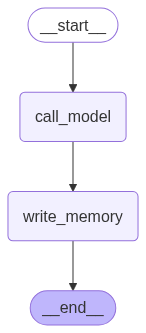

In [55]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatGroq(model=os.getenv("GROQ_MODEL_NAME"), temperature=0)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [56]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Pandhari")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Pandhari
================================== Ai Message ==================================

Hello Pandhari, it's nice to meet you. I don't have any prior information about you, so let's start fresh. Is there something I can help you with or would you like to chat? I'll make sure to remember our conversation for next time.


In [57]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

San Francisco is a beautiful city with a lot of great bike routes. I've updated my memory with your name and location, so I can address you personally next time. 

As for your interest in biking, San Francisco has many scenic bike paths, such as the Golden Gate Park, the Presidio, and the Embarcadero. Have you explored any of these routes, or is there a particular area you enjoy biking in?


In [58]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Pandhari',
  'user_location': 'San Francisco',
  'interests': ['biking']},
 'created_at': '2025-05-21T06:20:03.462596+00:00',
 'updated_at': '2025-05-21T06:20:03.462597+00:00'}

In [59]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Pandhari',
 'user_location': 'San Francisco',
 'interests': ['biking']}

In [60]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Bakeries can be a wonderful treat after a long bike ride. San Francisco has a vibrant food scene, with many excellent bakeries to choose from. I'll make sure to remember your interest in bakeries, along with your love of biking.

If you're looking for recommendations, I can suggest some popular bakeries in San Francisco. For example, there's Bi-Rite Bakery, Noe Valley Bakery, or even the famous Tartine Bakery. Have you tried any of these, or is there a particular type of baked good you enjoy?


In [61]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Pandhari, I'm glad you asked. Given your love for bakeries and your location in San Francisco, I'd like to recommend a few spots that are worth checking out. 

First, there's Bi-Rite Bakery, a popular spot in the Mission District that's known for its delicious pastries, bread, and cakes. They also have a great selection of sandwiches and salads if you're looking for a light bite.

Another great option is Noe Valley Bakery, which offers a wide variety of sweet and savory treats, including their famous sourdough bread. They also have a cozy atmosphere, making it a great spot to grab a coffee and pastry on a lazy morning.

If you're looking for something a bit more unique, you might want to try Tartine Bakery, which is known for its creative and delicious breads, pastries, and desserts. Th